In [1]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from collections import Counter

In [2]:
train_file = "/kaggle/input/chest-xray-pneumonia/chest_xray/train"
val_file = "/kaggle/input/chest-xray-pneumonia/chest_xray/test"
test_file = "/kaggle/input/chest-xray-pneumonia/chest_xray/val"

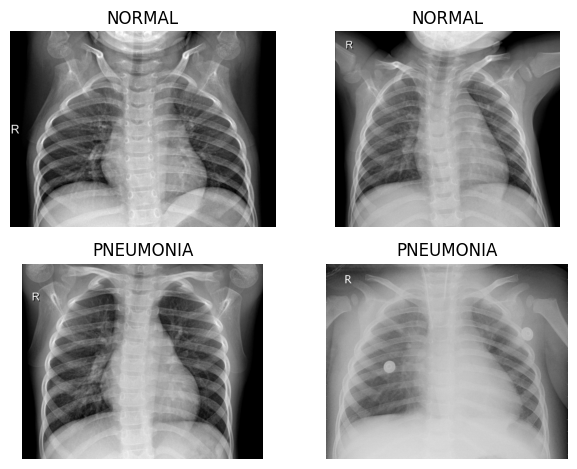

In [3]:
classes = ['NORMAL', 'PNEUMONIA']
i = 1
for cls in classes:
    cls_dir = os.path.join(train_file, cls)
    images = random.sample(
        [f for f in os.listdir(cls_dir) if f.lower().endswith((".jpg", ".jpeg"))],
        2
    )

    for img_name in images:
        img_path = os.path.join(cls_dir, img_name)
        img = Image.open(img_path)

        plt.subplot(2, 2, i)
        plt.imshow(img, cmap='gray')
        plt.title(cls)
        plt.axis("off")
        i += 1

plt.tight_layout()
plt.show()

In [4]:
IMG_SIZE = 244
BATCH_SIZE = 32
NUM_WORKERS = 2

train_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.15, contrast=0.15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229]) # Found by calculating the mean and std of the images in the dataset
])

eval_tfms = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485], std=[0.229])
])

train_ds = datasets.ImageFolder(train_file, transform=train_tfms)
val_ds   = datasets.ImageFolder(val_file, transform=eval_tfms)
test_ds  = datasets.ImageFolder(test_file, transform=eval_tfms)

# Weighted Sampling
targets = torch.tensor(train_ds.targets)  # list of 0/1 labels
class_counts = Counter(targets.tolist())
print("class_counts:", class_counts)
class_weights = torch.tensor([1.0 / class_counts[c] for c in sorted(class_counts.keys())], dtype=torch.float)

# weight per sample = class_weight[label]
sample_weights = class_weights[targets]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)
val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True
)

x, y = next(iter(train_loader))
print("x:", x.shape, x.dtype, "y:", y.shape, y[:10])

class_counts: Counter({1: 3875, 0: 1341})
x: torch.Size([32, 1, 244, 244]) torch.float32 y: torch.Size([32]) tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 1])


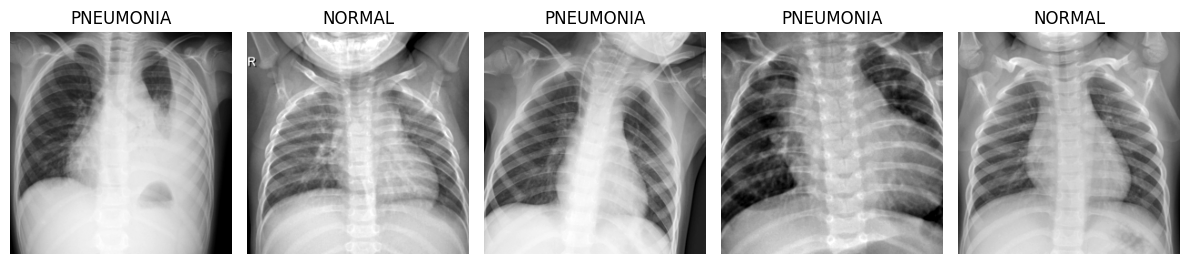

In [5]:
# get one batch from train_loader
images, labels = next(iter(train_loader))

# plot 5 images
plt.figure(figsize=(12, 3))

for i in range(5):
    img = images[i]          # [1, H, W]
    label = labels[i].item()

    plt.subplot(1, 5, i + 1)
    plt.imshow(img.squeeze(0), cmap="gray")
    plt.title("NORMAL" if label == 0 else "PNEUMONIA")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [6]:
class CNN_Model(nn.Module):
    def __init__(self, in_ch=1, num_classes=2, dropout=0.3):
        super().__init__()

        def block(cin, cout):
            return nn.Sequential(
                nn.Conv2d(cin, cout, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
                nn.Conv2d(cout, cout, kernel_size=3, padding=1, bias=False),
                nn.BatchNorm2d(cout),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),              # /2 spatial
                nn.Dropout2d(dropout),
            )

        self.features = nn.Sequential(
            block(in_ch, 32),    # 224 -> 112
            block(32, 64),       # 112 -> 56
            block(64, 128),      # 56 -> 28
            block(128, 256),     # 28 -> 14
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # 256 x 1 x 1
            nn.Flatten(),             # 256
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN_Model(in_ch=1, num_classes=2).to(device)

counts = torch.tensor([class_counts[0], class_counts[1]], dtype=torch.float)
loss_weights = (counts.sum() / (2.0 * counts)).to(device)  # inverse frequency, normalized-ish
criterion = nn.CrossEntropyLoss(weight=loss_weights)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-3)

In [ ]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad(set_to_none=True)
        logits = model(x)                 # [B, 2]
        loss = criterion(logits, y)       # y: [B] with class ids 0/1
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        running_loss += loss.item() * x.size(0)
        pred = logits.argmax(dim=1)
        correct += (pred == y).sum().item()
        total += y.size(0)

    return running_loss / total, correct / total


EPOCHS = 20
best_val_acc = 0.0
early_stop = 0

for epoch in range(1, EPOCHS + 1):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    print(f"Epoch {epoch:02d} | "
          f"train loss {train_loss:.4f} acc {train_acc:.4f} | "
          f"val loss {val_loss:.4f} acc {val_acc:.4f}")

    # save best checkpoint (optional)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_model.pt")
    else:
        early_stop += 1
        if early_stop == 3:
            print(f"Early Stopping after 3 epochs without improving!")
            break

print("Best val acc:", best_val_acc)

#### The model is overfitting due to the small dataset, images processing applications usually requires large scale of data to achieve a perfect generalization

In [42]:
@torch.no_grad()
def evaluate_metrics(model, loader, positive_label=1):
    model.load_state_dict(torch.load("/kaggle/working/best_model.pt", map_location=device))
    model.to(device)
    model.eval()

    tp = fp = tn = fn = 0
    total = 0
    correct = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        pred = logits.argmax(dim=1)

        correct += (pred == y).sum().item()
        total += y.numel()

        tp += ((pred == positive_label) & (y == positive_label)).sum().item()
        fp += ((pred == positive_label) & (y != positive_label)).sum().item()
        tn += ((pred != positive_label) & (y != positive_label)).sum().item()
        fn += ((pred != positive_label) & (y == positive_label)).sum().item()

    acc = correct / total if total else 0.0
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "tp": tp, "fp": fp, "tn": tn, "fn": fn
    }

In [44]:
# Example usage (pick val_loader or test_loader)
metrics = evaluate_metrics(model, test_loader, positive_label=1)  # 1 usually = PNEUMONIA
print(metrics)
print(f"Accuracy : {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall   : {metrics['recall']:.4f}")
print(f"Confusion (TP FP TN FN): {metrics['tp']} {metrics['fp']} {metrics['tn']} {metrics['fn']}")

{'accuracy': 0.8397435897435898, 'precision': 0.8222222222222222, 'recall': 0.9487179487179487, 'tp': 370, 'fp': 80, 'tn': 154, 'fn': 20}
Accuracy : 0.8397
Precision: 0.8222
Recall   : 0.9487
Confusion (TP FP TN FN): 370 80 154 20


In [51]:
@torch.no_grad()
def show_correct_and_misclassified(model, loader):
    model.eval()

    mean, std = 0.5667, 0.1798
    correct_shown = 0
    wrong_shown = 0

    plt.figure(figsize=(12, 8))

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        pred = model(x).argmax(dim=1)

        for i in range(len(y)):
            img = x[i].cpu() * std + mean
            img = img.clamp(0, 1)

            # correct
            if pred[i] == y[i] and correct_shown < 6:
                correct_shown += 1
                plt.subplot(3, 4, correct_shown)
                plt.imshow(img.squeeze(0), cmap="gray")
                plt.title(f"✓ T:{'NORMAL' if y[i]==0 else 'PNEUMONIA'}")
                plt.axis("off")

            # misclassified
            elif pred[i] != y[i] and wrong_shown < 6:
                wrong_shown += 1
                plt.subplot(3, 4, 6 + wrong_shown)
                plt.imshow(img.squeeze(0), cmap="gray")
                plt.title(f"✗ T:{'NORMAL' if y[i]==0 else 'PNEUMONIA'} | "
                          f"P:{'NORMAL' if pred[i]==0 else 'PNEUMONIA'}")
                plt.axis("off")

            if correct_shown == 6 and wrong_shown == 6:
                plt.tight_layout()
                plt.show()
                return

    plt.tight_layout()
    plt.show()

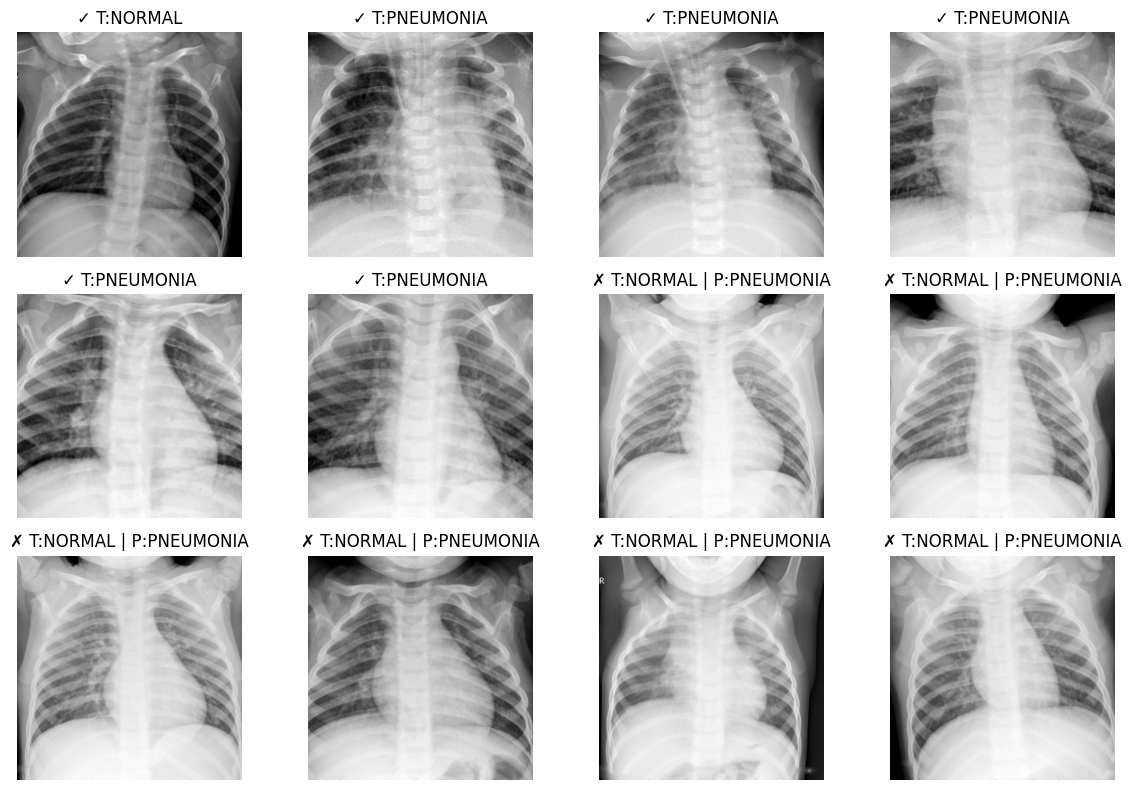

In [53]:
show_correct_and_misclassified(model, val_loader)